In [8]:
!pip install opencv-python-headless scenedetect docarray torch torchvision transformers scikit-learn matplotlib moviepy

In [9]:
import cv2
import numpy as np
from scenedetect import detect, ContentDetector
from docarray import BaseDoc, DocList
from docarray.typing import NdArray, TorchTensor
from PIL import Image
import torch
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.cluster import KMeans
from transformers import pipeline
import matplotlib.pyplot as plt
import moviepy.editor as mp


In [10]:
class VideoFrame(BaseDoc):
    frame_number: int
    image: NdArray[3, 224, 224]
    features: TorchTensor[2048]
    description: str

class VideoScene(BaseDoc):
    start_frame: int
    end_frame: int
    keyframes: DocList[VideoFrame]
    representative_frame: VideoFrame

class Video(BaseDoc):
    path: str
    scenes: DocList[VideoScene]
    summary: str

In [11]:
def extract_frames(video_path, scene_list):
    cap = cv2.VideoCapture(video_path)
    frames = []
    for scene in scene_list:
        cap.set(cv2.CAP_PROP_POS_FRAMES, scene[0].frame_num)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append((scene[0].frame_num, frame))
    cap.release()
    return frames

def preprocess_image(image):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(Image.fromarray(image)).unsqueeze(0)

def extract_features(model, image, device):
    with torch.no_grad():
        features = model(image.to(device))
    return features.cpu().squeeze().numpy()

def process_video(video_path, image_model, image_captioner, device):
    # Detect scenes
    scene_list = detect(video_path, ContentDetector())

    # Extract frames
    frames = extract_frames(video_path, scene_list)

    # Process frames and create DocArray
    video = Video(path=video_path, scenes=DocList[VideoScene]())

    for i, scene in enumerate(scene_list):
        start_frame, end_frame = scene[0].frame_num, scene[-1].frame_num
        scene_frames = [frame for frame in frames if start_frame <= frame[0] <= end_frame]

        keyframes = DocList[VideoFrame]()
        for frame_num, frame in scene_frames:
            processed_image = preprocess_image(frame)
            features = extract_features(image_model, processed_image, device)

            # Generate image description
            # Convert the frame to PIL Image for the captioner
            pil_image = Image.fromarray(frame)
            description = image_captioner(pil_image)[0]['generated_text']

            keyframe = VideoFrame(
                frame_number=frame_num,
                image=processed_image.squeeze().numpy(),
                features=features,
                description=description
            )
            keyframes.append(keyframe)

        # Select representative frame (middle frame for simplicity)
        representative_frame = keyframes[len(keyframes) // 2]

        video_scene = VideoScene(
            start_frame=start_frame,
            end_frame=end_frame,
            keyframes=keyframes,
            representative_frame=representative_frame
        )
        video.scenes.append(video_scene)

    return video

def summarize_video(video, num_keyframes=5):
    # Collect all frame features
    all_features = np.vstack([frame.features for scene in video.scenes for frame in scene.keyframes])

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_keyframes, random_state=42)
    kmeans.fit(all_features)

    # Find the frames closest to the cluster centers
    summary_frames = []
    for center in kmeans.cluster_centers_:
        distances = np.linalg.norm(all_features - center, axis=1)
        closest_frame_index = np.argmin(distances)
        for scene in video.scenes:
            if closest_frame_index < len(scene.keyframes):
                summary_frames.append(scene.keyframes[closest_frame_index])
                break
            closest_frame_index -= len(scene.keyframes)

    # Generate summary text
    summary_text = "Video Summary:\n\n"
    for i, frame in enumerate(summary_frames, 1):
        summary_text += f"{i}. {frame.description}\n"

    video.summary = summary_text
    return summary_frames, summary_text

def create_summary_video(video_path, summary_frames, output_path, duration_per_frame=3):
    # Load the original video
    video = mp.VideoFileClip(video_path)

    # Create clips for each summary frame
    clips = []
    for frame in summary_frames:
        frame_time = frame.frame_number / video.fps
        clip = video.subclip(frame_time, frame_time + duration_per_frame)
        clips.append(clip)

    # Concatenate the clips
    final_clip = mp.concatenate_videoclips(clips)

    # Write the summary video
    final_clip.write_videofile(output_path, codec="libx264")

def visualize_summary(summary_frames):
    fig, axes = plt.subplots(1, len(summary_frames), figsize=(20, 4))
    for i, frame in enumerate(summary_frames):
        axes[i].imshow(np.transpose(frame.image, (1, 2, 0)))
        axes[i].axis('off')
        axes[i].set_title(f"Frame {frame.frame_number}")
    plt.tight_layout()
    plt.show()

In [12]:
# Initialize models and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_model = resnet50(weights=ResNet50_Weights.DEFAULT)
image_model = torch.nn.Sequential(*list(image_model.children())[:-1])
image_model.to(device)
image_model.eval()


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [13]:
image_captioner = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base", device=device)

In [14]:
# Process video
video_path = "/content/videoplayback.mp4"
processed_video = process_video(video_path, image_model, image_captioner, device)


INFO:pyscenedetect:Downscale factor set to 2, effective resolution: 320 x 180
INFO:pyscenedetect:Detecting scenes...
  warnings.warn(



In [15]:
# Generate summary
summary_frames, summary_text = summarize_video(processed_video)


  warnings.warn(



In [16]:
# Print text summary
print(summary_text)

Video Summary:

1. a group of children playing on swings in a park
2. a man is standing on a pink slide
3. a young boy playing on a playground slide
4. a group of people playing with a ball
5. a little boy playing on a playground



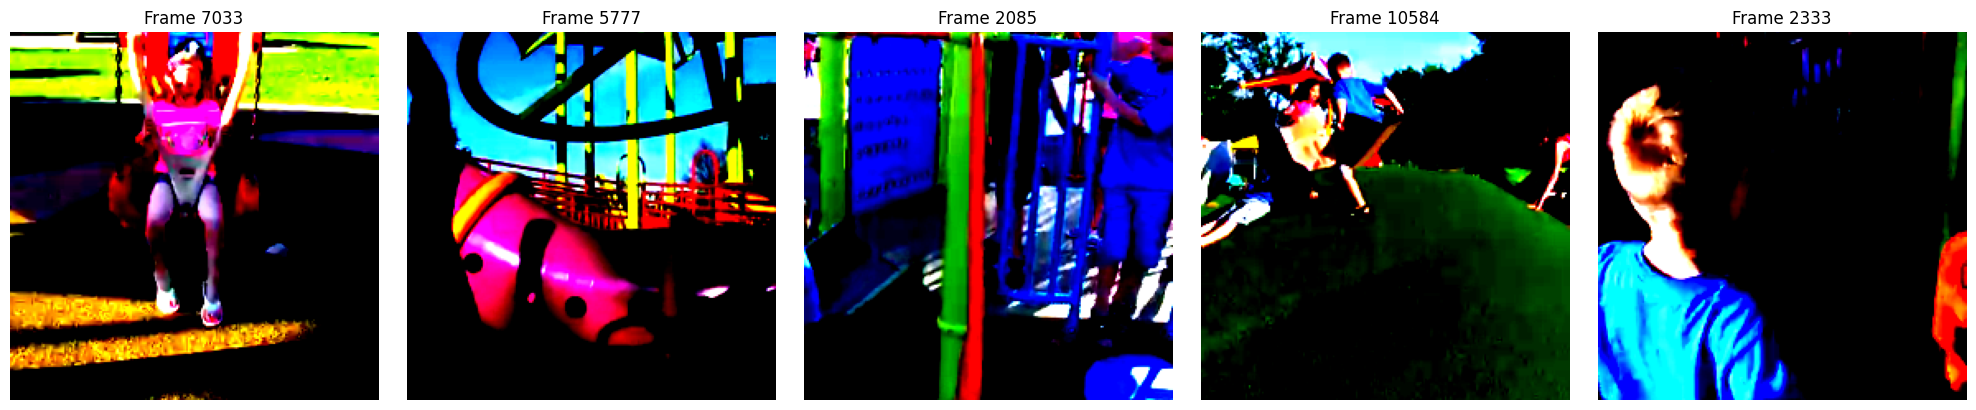

In [17]:
# Visualize summary frames
visualize_summary(summary_frames)


In [18]:
# Create summary video
output_path = "summary_video.mp4"
create_summary_video(video_path, summary_frames, output_path)
print(f"Summary video saved to {output_path}")

Moviepy - Building video summary_video.mp4.
MoviePy - Writing audio in summary_videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video summary_video.mp4



Moviepy - Done !
Moviepy - video ready summary_video.mp4
